In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from pinns import *

In [2]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device2 = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

## Solving
####  $\nabla^2 u(x,y) = 0$,
## For boundary condition
#### $u(0, y) = \sin(\pi y)$,
#### $u(1, y) = 0$,
#### $u(x, 0) = 0$,
#### $u(x, 1) = 0$.

## Solution
#### $u(x,y) = \sum_{n=0}^{\infty} A_n \sinh[(n+1)\pi (x-1)] \sin[(n+1)\pi y]$,
#### for
#### $A_n = -\frac{2}{ \sinh((n+1)\pi)} \int_0^1 \sin(\pi y)\sin((n+1)\pi y) dy =  -\frac{2 \sin(n \pi)}{n \pi(n+2)\sinh((n+1)\pi) } 
= \begin{cases} - \frac{1}{\sinh \pi } &, n=0 \\ 0 &, otherwise \end{cases}$
## So,
### $u(x,y) = - \frac{\sinh (\pi(x-1)) \sin(\pi y)}{\sinh \pi } $

[link](https://en.wikiversity.org/wiki/Partial_differential_equations/Laplace_Equation)

In [3]:
def exact_solution(x,y,sin=np.sin, sinh=np.sinh):
    return -sinh(np.pi*(x-1))*sin(np.pi*y)/np.sinh(np.pi)

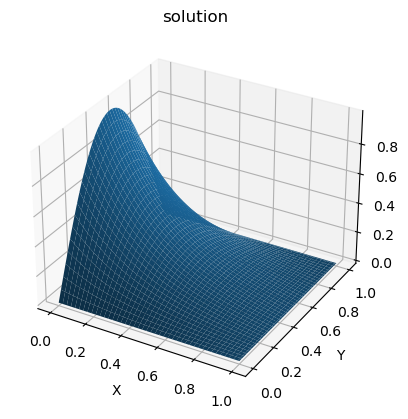

In [4]:
x = np.linspace(0, 1, 128)#[1:-1]
y = np.linspace(0, 1, 128)#[1:-1]
X,Y = np.meshgrid(x, y, indexing='ij')

sol = exact_solution(X, Y)

def plot_surf(X,Y, sol, scatter=False):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    if scatter:
        ax.scatter(X,Y,sol, marker='.')
    else:
        ax.plot_surface(X,Y,sol)
    plt.title("solution"); plt.xlabel("X"); plt.ylabel("Y")    
    plt.show()
plot_surf(X,Y, sol)

In [13]:
x = torch.linspace(0, 1, 128).to(device)
y = torch.linspace(0, 1, 128).to(device)
X,Y = torch.meshgrid(x, y, indexing='ij')


boundary_X_x = torch.hstack([x, 
                             x,
                             torch.ones_like(y)*x[0].item(), 
                             torch.ones_like(y)*x[-1].item()])
boundary_X_y = torch.hstack([torch.ones_like(x)*y[0].item(), 
                             torch.ones_like(x)*y[-1].item(),
                             y,
                             y])
boundary_X = torch.vstack([boundary_X_x, boundary_X_y]).T#.requires_grad_(True)
def boundary_function(x):
    return torch.where( x[:, 0] == 0, 
                       torch.sin(np.pi*x[:, 1]), 
                       0)

boundary_f = boundary_function(boundary_X).to(device)

physics_X = torch.vstack([X.flatten(), Y.flatten()]).T.requires_grad_(True).to(device)

lb = torch.tensor([0., 0.]).to(device)
ub = torch.tensor([1., 1.]).to(device)
model = Net_dense_normalised([2, 128, 128, 128, 128, 1], lb, ub).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
epochs = 50000
loss_boundary = 0.0
lambda_boundary = 1.0
loss_physics = 0.0
lambda_physics = 1e-3

actual_f = exact_solution(X, Y, sin=torch.sin, sinh=torch.sinh).flatten()
losses = np.zeros((2, epochs))
rmses = np.zeros( epochs)

for i in range(epochs):
    optimizer.zero_grad()

    #################################
    # boundary loss
    boundary_f_hat = model(boundary_X).squeeze()
    loss_boundary = torch.mean((boundary_f - boundary_f_hat)**2)

    #################################
    # physics derivatives
    physics_f = model(physics_X).squeeze()
    dxy  = torch.autograd.grad(physics_f, physics_X, torch.ones_like(physics_f), create_graph=True)[0]# computes dy/dx
    dx, dy = dxy[:,0], dxy[:,1]
    dxy2 = torch.autograd.grad(dx, physics_X, torch.ones_like(dx),  create_graph=True)[0]# computes d^2u/dx^2
    dx2 =  dxy2[:,0]
    dyx2 = torch.autograd.grad(dy, physics_X, torch.ones_like(dy),  create_graph=True)[0]# computes d^2u/dy^2
    dy2 =  dyx2[:,1]
    laplacian = dx2 + dy2
    ################################
    # physics loss
    # Construct the physics loss here
    loss_physics = torch.mean(laplacian**2)    
    
    total_loss = (
        +lambda_boundary*loss_boundary
        +lambda_physics*loss_physics
                    )

    total_loss.backward(retain_graph=True)
    optimizer.step()
    losses[:,i] = (loss_boundary.item(), loss_physics.item())
    f = model(physics_X).squeeze()
    rmses[i] = torch.sqrt(torch.mean((actual_f-f)**2)).item()


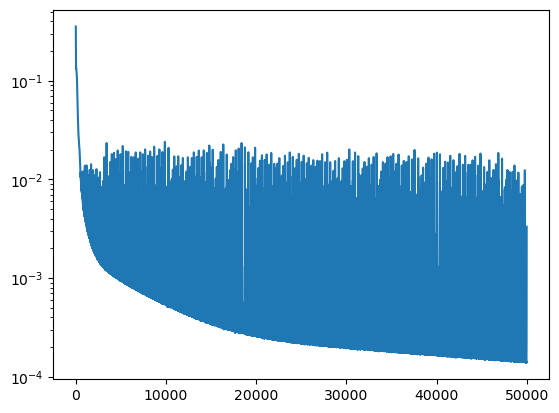

In [14]:
plt.plot(rmses);plt.yscale('log')

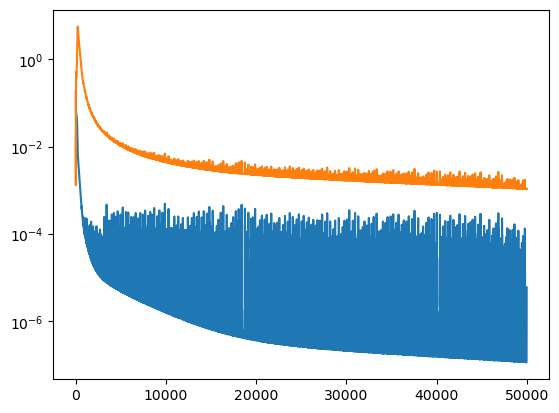

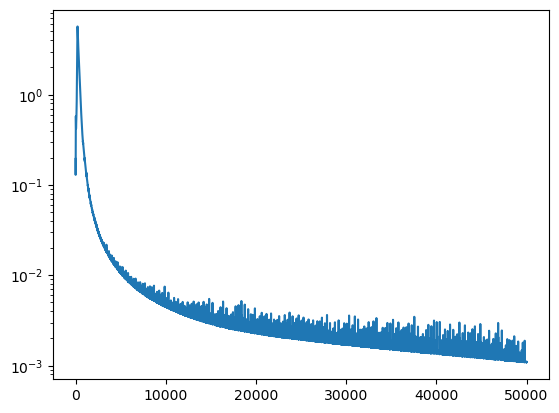

In [15]:
plt.plot(losses[0,:])
plt.plot(losses[1,:])
plt.yscale('log'); plt.show()
plt.plot(np.sum(losses, axis=0))
plt.yscale('log'); plt.show()

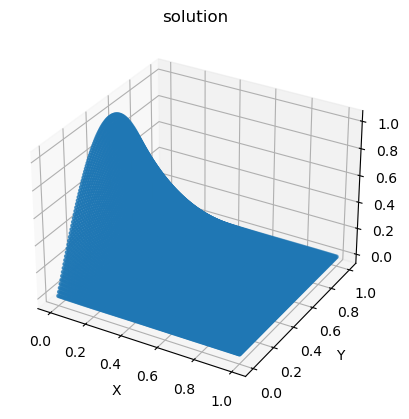

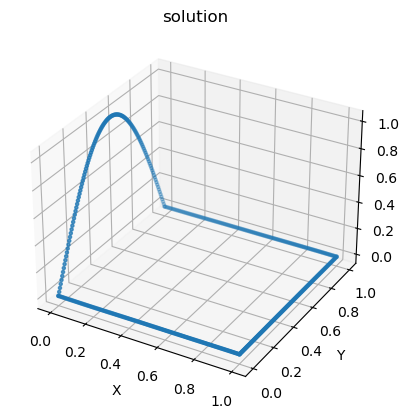

In [18]:
solution = model(physics_X).cpu().detach()
plot_surf(physics_X[:,0].cpu().detach(), 
          physics_X[:,1].cpu().detach(),
          solution,
          scatter=True)
boundary_solution = model(boundary_X).cpu().detach()
plot_surf(boundary_X[:,0].cpu().detach(), 
          boundary_X[:,1].cpu().detach(),
          boundary_solution,
          scatter=True)

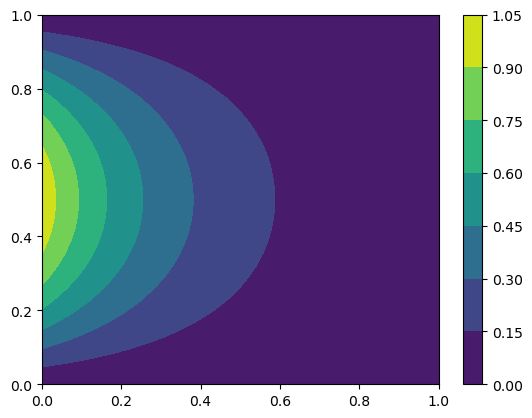

In [19]:
x = torch.linspace(0, 1, 32).to(device)
y = torch.linspace(0, 1, 32).to(device)
X,Y = torch.meshgrid(x, y, indexing='ij')
solution = model(torch.vstack([X.flatten(), Y.flatten()]).T).cpu().detach().reshape((x.shape[0], y.shape[0]))
plt.contourf(X.cpu().detach(), Y.cpu().detach(), solution)
plt.colorbar()